# Keras PFN and PFN with mdn layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
data_path = path_prefix + "v7/"
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/"
ext_plotpath = ext_path + "plots/"

In [3]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    ''' Note that non masked values are left alone i.e. zeros if mask = arr != 0'''
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

In [4]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [5]:
stmc_x = np.load(data_path + "X_img_pfn.npz")
stmc_y = np.load(data_path + "Y_img_pfn.npz")

In [6]:
t0 = t.time()
# load data from NpzFile
Xraw = stmc_x.f.arr_0
Yraw = stmc_y.f.arr_0

# load spcific amount of events from raw
X = Xraw[:,:,:4]
Y = Yraw[:]
print(X.shape)
print(Y.shape)
t1 = t.time()
print('Time to load and copy arrays: '+str(t1-t0)+' (s)')

(435967, 636, 4)
(435967,)
Time to load and copy arrays: 9.686999797821045 (s)


In [7]:
# for PFN approach Y normalization
# the target energy values
# target_zero_mask, Y : 0 for truthPartE, 1 for truthTrackPt, 2 for cluster_eng_clib_tot
target_zero_mask = Y > 0.05
Ylog = np.log(Y[target_zero_mask])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Ylog)))

Any targets below 50 GeV: 6154
Number of events: 429813


In [8]:
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
scaler = StandardScaler()
Y_sd = scaler.fit_transform(Ylog.reshape(-1,1))
dump(scaler, "standard_scaler.bin")

['standard_scaler.bin']

In [9]:
# for pfn approach X normalization
# X = [Energy, Eta, Phi, rPerp]

## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask] / 0.7

phi_mask = X[:,:,2] != 0
X[:,:,2][phi_mask] = X[:,:,2][phi_mask] / np.std(X[:,:,2][phi_mask])

<Figure size 799.992x599.976 with 0 Axes>

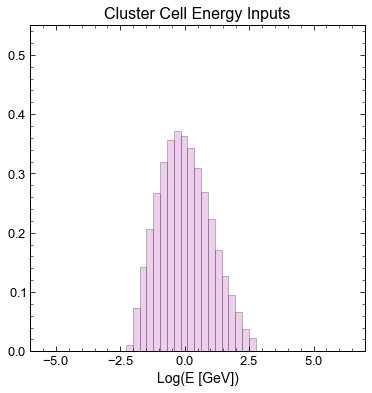

<Figure size 799.992x599.976 with 0 Axes>

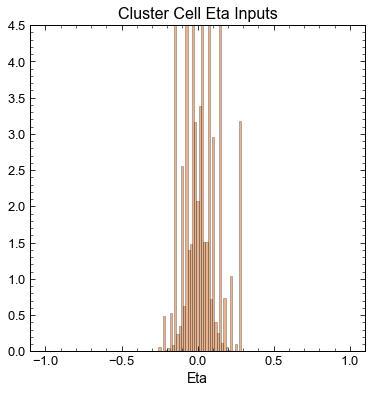

<Figure size 799.992x599.976 with 0 Axes>

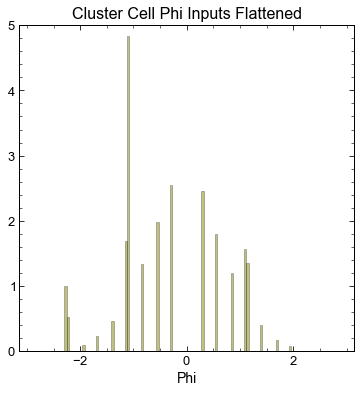

<Figure size 799.992x599.976 with 0 Axes>

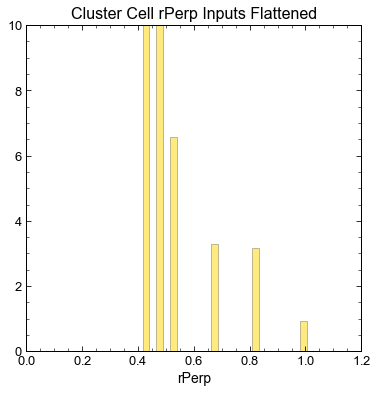

In [10]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_Einputs_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1, 150, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_EtaInputs_2021-07-08.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi,np.pi,150, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_PhiInputs_2021-07-08.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_rPerpInputs_2021-07-08.png', format='png')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as Kb

In [12]:
import energyflow as ef
from energyflow.archs import PFN

# Models

In [13]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X[target_zero_mask], _tvt=(80, 5, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

RMS_prop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

train -- val -- test
343850 -- 21491 -- 64472


In [14]:
# dataset = tf.data.Dataset.from_tensor_slices((X, Y))
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X[target_zero_mask], Y_sd, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(343850, 636, 4)
(343850, 1)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 799.992x599.976 with 0 Axes>

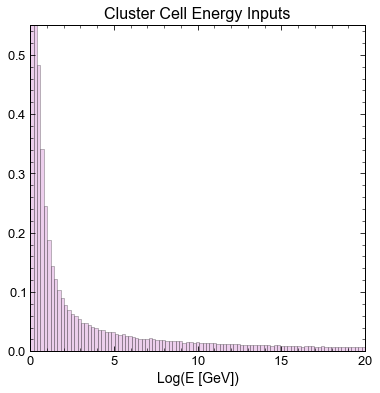

In [15]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(0,20, 100, endpoint=True)
plt.hist(Y[target_zero_mask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 799.992x599.976 with 0 Axes>

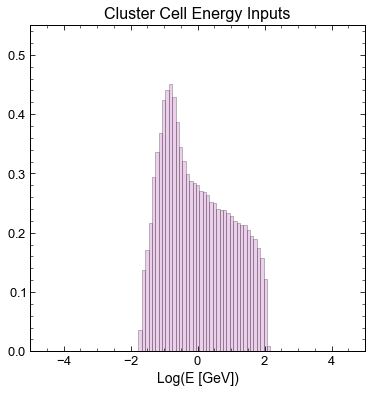

In [16]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-5,5, 100, endpoint=True)
plt.hist(Y_sd, color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [17]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [18]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

In [19]:
"""import keras as K
import keras.backend as Kb
from tensorflow.keras import activations
import keras_tuner as kt

def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))


def ParticleFlow_tuner(num_features, name="RussellFlowNetwork"):

    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100,name='td_0', activation=activations.relu)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    
    dense_1 = layers.Dense(100,name='td_1', activation=activations.relu)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(t_dist_0)
    
    dense_2 = layers.Dense(128,name='td_2', activation=activations.relu)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(t_dist_1)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, t_dist_2])
    
    dense_3 = layers.Dense(100, name='dense_0', activation=activations.relu)(sum_layer)
    
    dense_4 = layers.Dense(100, name='dense_1')(dense_3)
    
    dense_5 = layers.Dense(100, name='dense_2', activation=activations.relu)(dense_4)
    
    dense_6 = layers.Dense(1, name='output', activation=activations.relu)(dense_5)
    
    return keras.Model(inputs=inputs, outputs=dense_6, name=name)"""

'import keras as K\nimport keras.backend as Kb\nfrom tensorflow.keras import activations\nimport keras_tuner as kt\n\ndef point_mask_fn(X, mask_val=0.):\n    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))\n\n\ndef ParticleFlow_tuner(num_features, name="RussellFlowNetwork"):\n\n    inputs = keras.Input(shape=(None, num_features), name=\'input\')\n\n    dense_0 = layers.Dense(100,name=\'td_0\', activation=activations.relu)\n    t_dist_0 = layers.TimeDistributed(dense_0, name=\'t_dist_0\')(inputs)\n    \n    dense_1 = layers.Dense(100,name=\'td_1\', activation=activations.relu)\n    t_dist_1 = layers.TimeDistributed(dense_1, name=\'t_dist_1\')(t_dist_0)\n    \n    dense_2 = layers.Dense(128,name=\'td_2\', activation=activations.relu)\n    t_dist_2 = layers.TimeDistributed(dense_2, name=\'t_dist_2\')(t_dist_1)\n    \n    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),\n                                mask=None,\n                              

In [20]:
"""Kb.clear_session()

PFN_mdn = ParticleFlow_tuner(num_features=4)
PFN_mdn.compile(optimizer = netOpt, loss="mse")
PFN_mdn.summary()"""

'Kb.clear_session()\n\nPFN_mdn = ParticleFlow_tuner(num_features=4)\nPFN_mdn.compile(optimizer = netOpt, loss="mse")\nPFN_mdn.summary()'

In [21]:
pfn = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [22]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('img_pfn_regressor_stdE_1.h5', monitor='loss', verbose=1, save_best_only=True, save_weight_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)
t0 = t.time()
history_ct = pfn.fit(x_train, y_train,
        epochs=1000,
        batch_size=500,
        validation_data=(x_val, y_val),
        verbose=0,
        callbacks=[chkpoint, earlystop])
t1 = t.time()


Epoch 00001: loss improved from inf to 23.24547, saving model to img_pfn_regressor_stdE_1.h5

Epoch 00002: loss improved from 23.24547 to 0.23080, saving model to img_pfn_regressor_stdE_1.h5

Epoch 00003: loss did not improve from 0.23080

Epoch 00004: loss did not improve from 0.23080

Epoch 00005: loss did not improve from 0.23080

Epoch 00006: loss improved from 0.23080 to 0.10211, saving model to img_pfn_regressor_stdE_1.h5

Epoch 00007: loss did not improve from 0.10211

Epoch 00008: loss did not improve from 0.10211

Epoch 00009: loss did not improve from 0.10211

Epoch 00010: loss improved from 0.10211 to 0.05004, saving model to img_pfn_regressor_stdE_1.h5

Epoch 00011: loss did not improve from 0.05004

Epoch 00012: loss did not improve from 0.05004

Epoch 00013: loss improved from 0.05004 to 0.03707, saving model to img_pfn_regressor_stdE_1.h5

Epoch 00014: loss did not improve from 0.03707

Epoch 00015: loss improved from 0.03707 to 0.03210, saving model to img_pfn_regresso

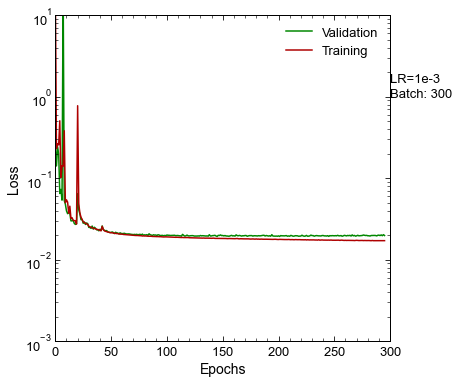

In [23]:
#loss curve
fig = plt.figure(figsize=(6,6))
plt.plot(history_ct.history['val_loss'], label="Validation")
plt.plot(history_ct.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,300)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(300, 1.5, 'LR=1e-3', fontsize=13)
plt.text(300, 1, 'Batch: 300', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [61]:
preds_all = pfn.predict(eval_generator(X[target_zero_mask],500))
pred_all = np.exp(scaler.inverse_transform(preds_all)).reshape(-1)
y_all = np.exp(scaler.inverse_transform(Y_sd.reshape(1, -1))).reshape(-1)

In [68]:
preds = pfn.predict(eval_generator(x_test,500))
y = np.exp(scaler.inverse_transform(y_test.reshape(1, -1))).reshape(-1)
pred = np.exp(scaler.inverse_transform(preds)).reshape(-1)

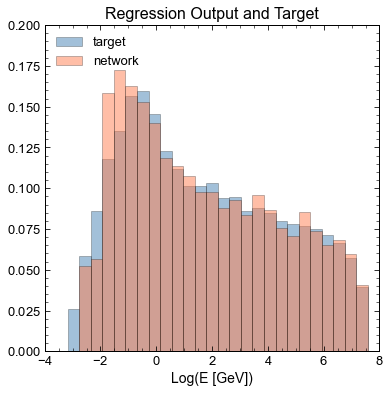

In [79]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-4,8,30, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.log(y), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(pred), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-4,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [37]:
y_test.shape

(64472, 1)

In [38]:
preds.shape

(64472,)

<Figure size 799.992x599.976 with 0 Axes>

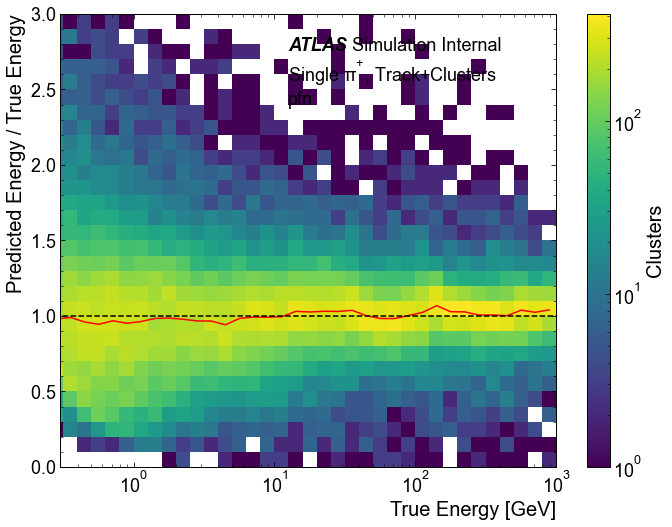

In [69]:
xcenter, medDNN = ru.responsePlot(x=y, y=pred/y,
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'pfn'}])

<Figure size 799.992x599.976 with 0 Axes>

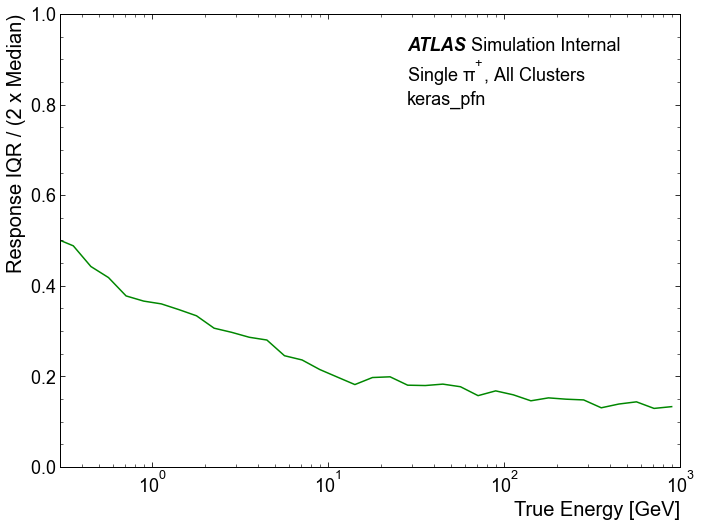

In [70]:
xcenter, iqrMDN3 = resolutionPlot(pred, y,
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'keras_pfn'}])

<Figure size 799.992x599.976 with 0 Axes>

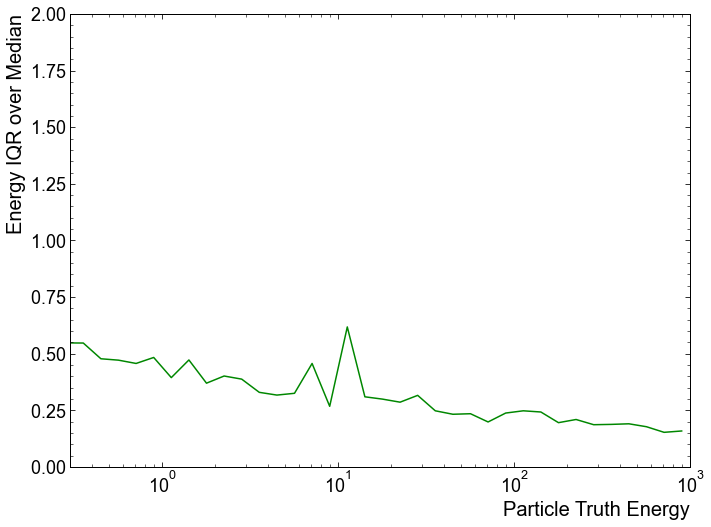

In [72]:
resp_plot = ru.resolutionPlot(x=y, y=pred/y,
                    figfile='',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=-1, atlas_y=-1, simulation=False,
                    textlist=[])

In [ ]:
resid_DNN = preds[:,0] - np.exp(y_test)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.ylabel('Clusters')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'keras_pfn'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [73]:
def histogramSlices(x, ylist, labels=[''], xstep=0.2, statistic='iqr', title = 'Response',
                 xlabel='Predicted Energy / True Energy', ylabel='Clusters', alpha=1.,
                 xlim=(0.3,1000.), ylim=(0.,3.1), binsize=0.05, baseline=False, logscale=False, density=False,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    
    if type(ylist) != type([]):
        ylist = [ylist]

    xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    last_xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    
    ybin = np.arange(ylim[0], ylim[1], binsize)

    plt.cla()
    plt.clf()

    for xbin_left,xbin_right in zip(last_xbin,xbin[1:]):
        fig = plt.figure()
        val_mask = np.logical_and(x > xbin_left, x < xbin_right)

        for y,label in zip(ylist,labels):
            if statistic == 'iqr':
                med = np.median(y[val_mask])
                iqr = np.percentile(y[val_mask], q=84) - np.percentile(y[val_mask], q=16)
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Median = {:.2f}, IQR = {:.2f}'.format(med, iqr),
                         alpha=alpha)
            elif statistic == 'std':
                mu = np.mean(y[val_mask])
                sig = np.std(y[val_mask])
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Mean = {:.2f}, Std. Dev. = {:.2f}'.format(mu, sig),
                         alpha=alpha)
            else:
                plt.hist(y[val_mask], bins=ybin, density=density,
                         label = label,
                         alpha=alpha)
            
            if baseline:
                x1 = np.linspace(-6,6,100)
                pdf = stats.norm.pdf(x1)
                plt.plot(x1, pdf, label='Unit Normal')

        if len(textlist) >= 2:
            textlist[1]['text'] = '{:.4g} - {:.4g} GeV Clusters'.format(xbin_left, xbin_right)
            pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

        if logscale:
            plt.yscale('log')

        # plt.title(title + ' {:.4g} - {:.4g} GeV'.format(xbin_left, xbin_right))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(ylim)
        plt.legend()
        plt.show()

In [ ]:
np.median(preds[:,0]/np.exp(y_test))

<Figure size 799.992x599.976 with 0 Axes>

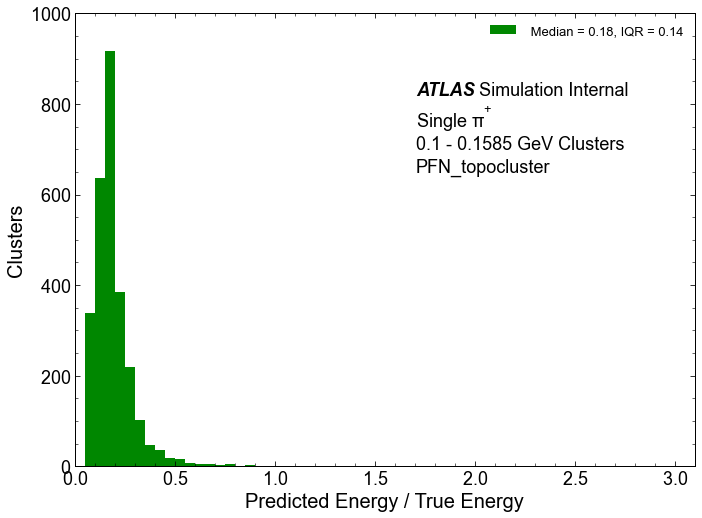

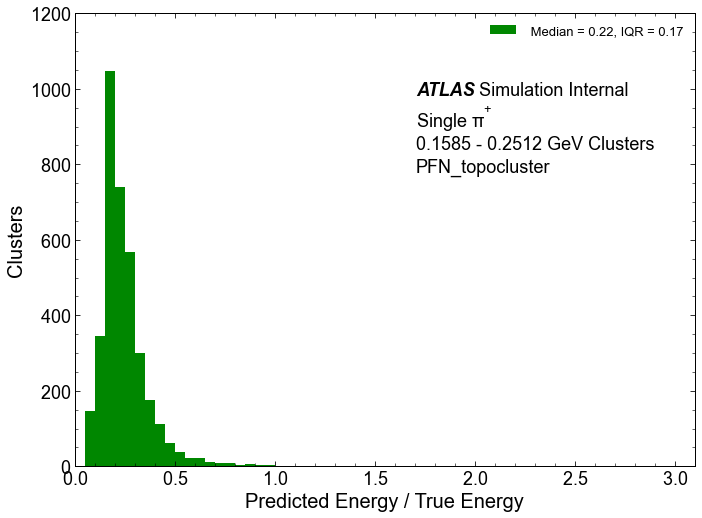

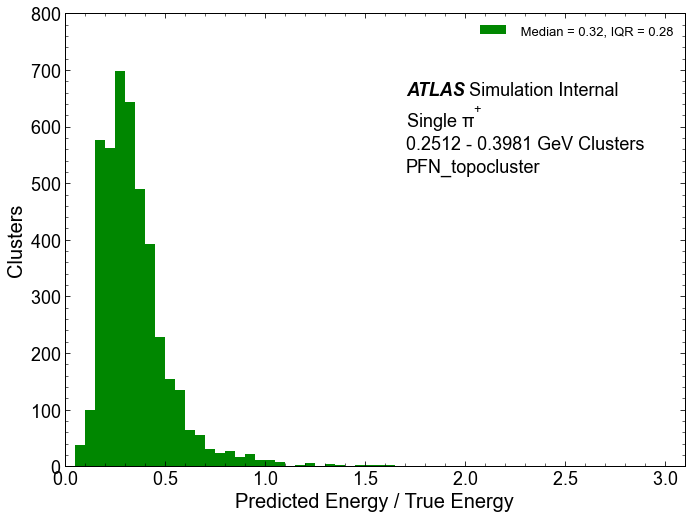

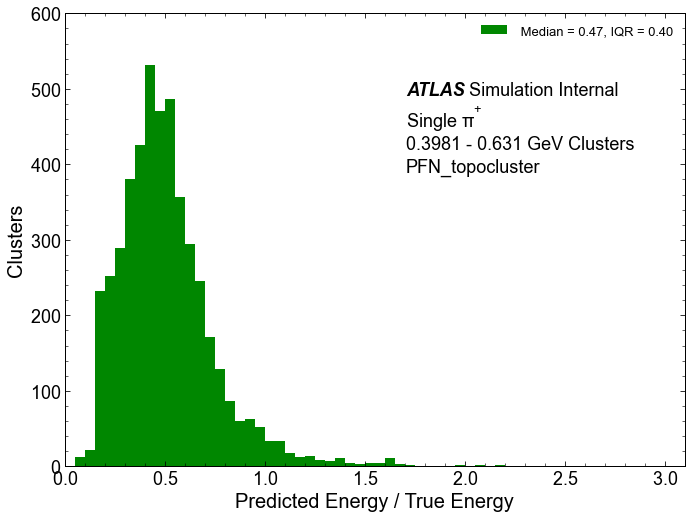

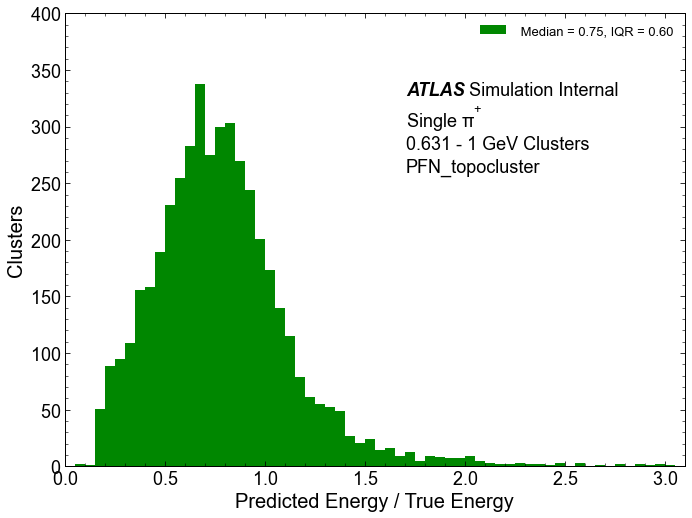

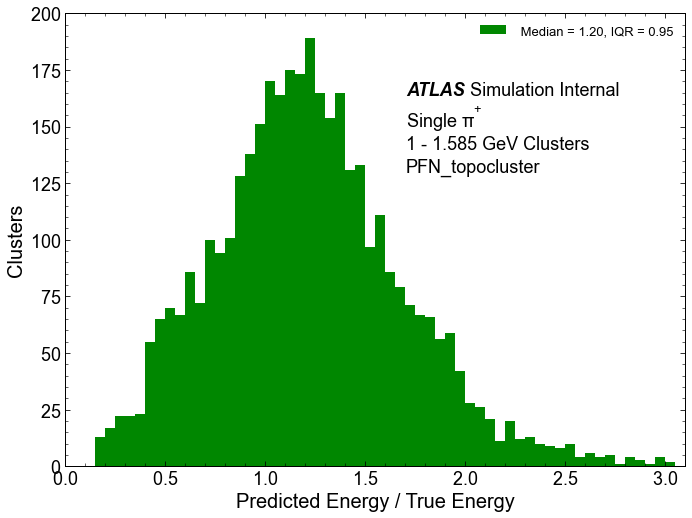

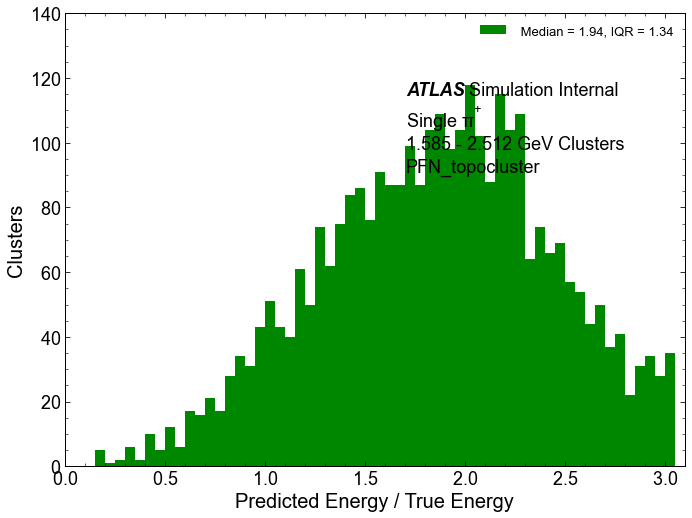

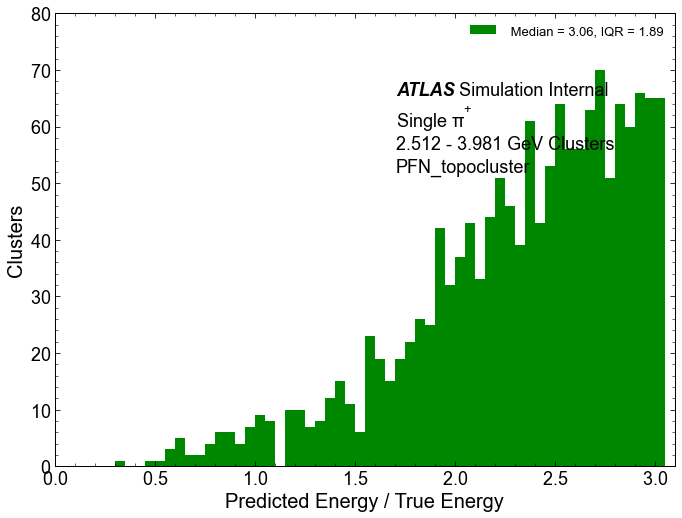

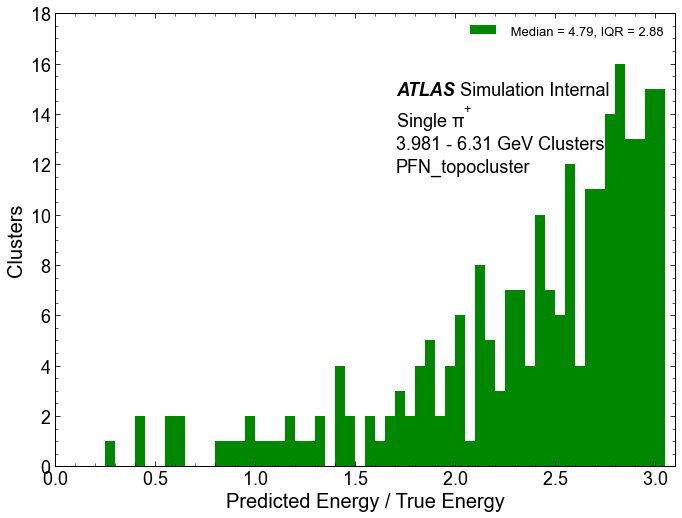

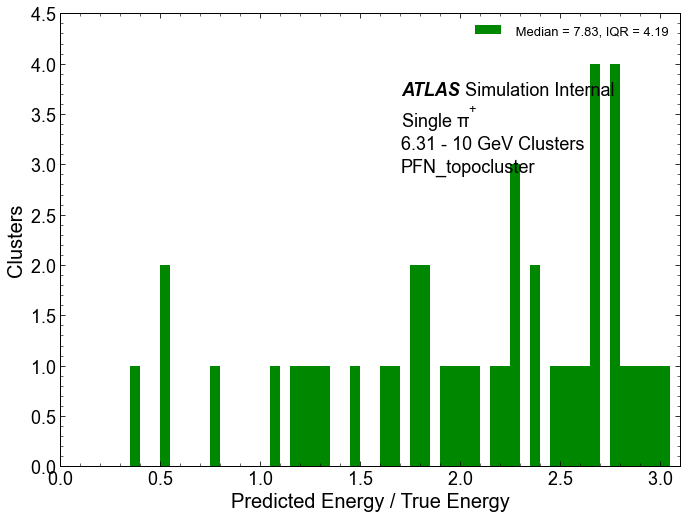

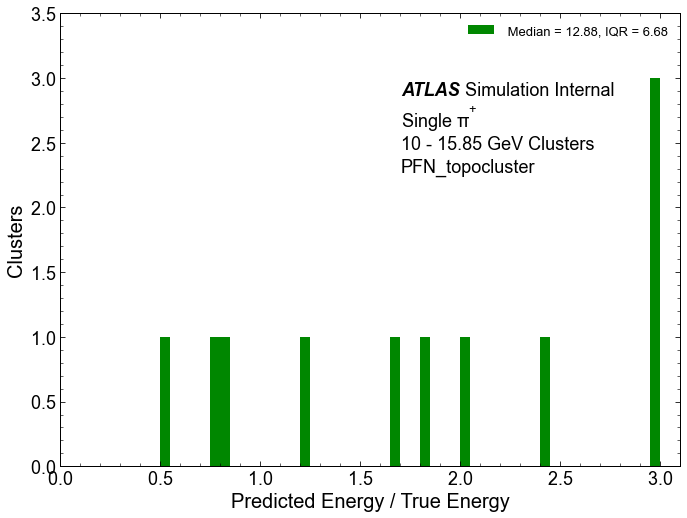

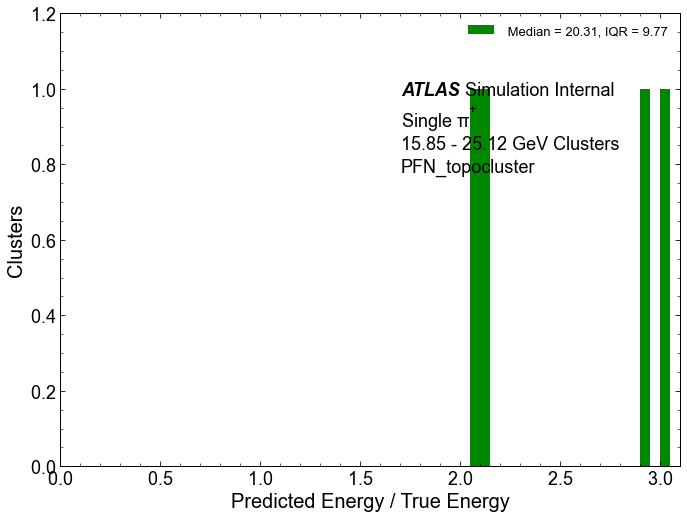

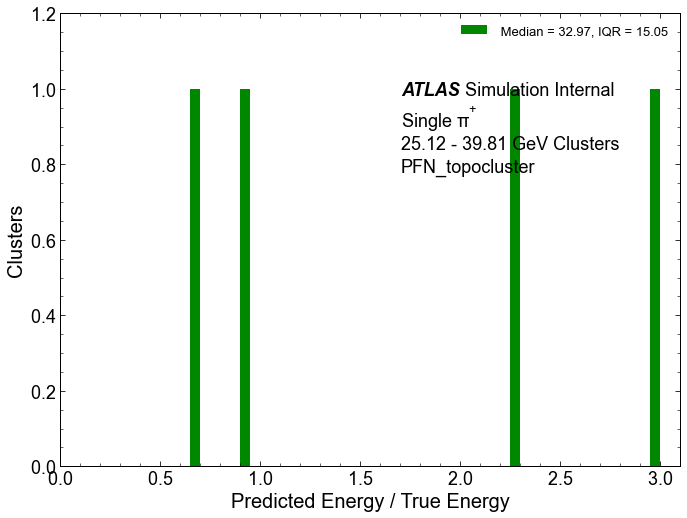

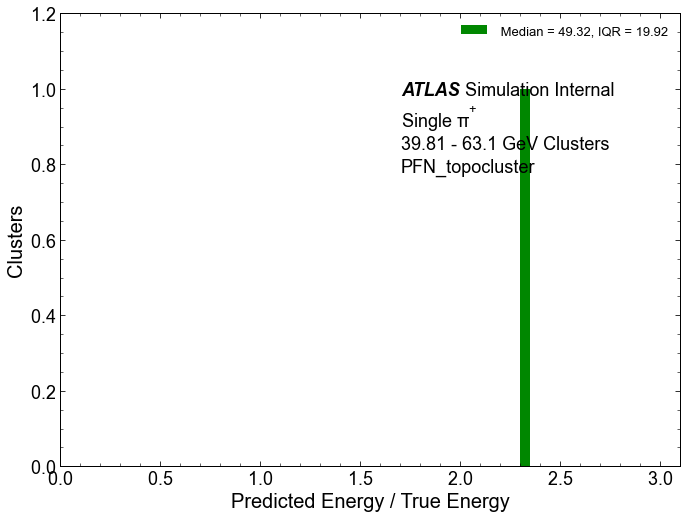

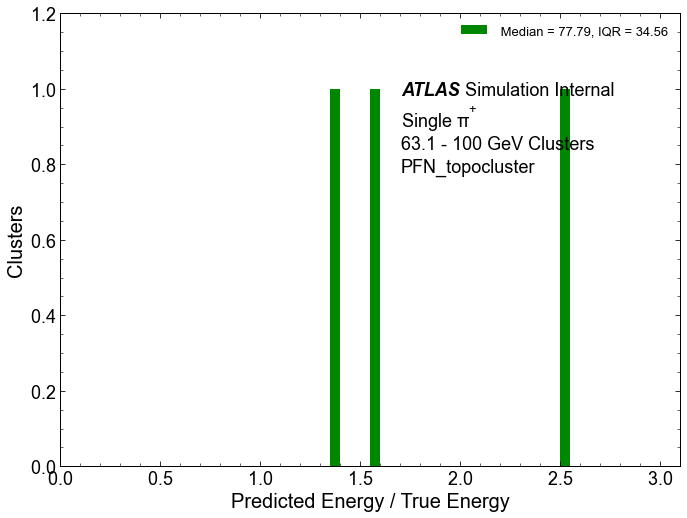

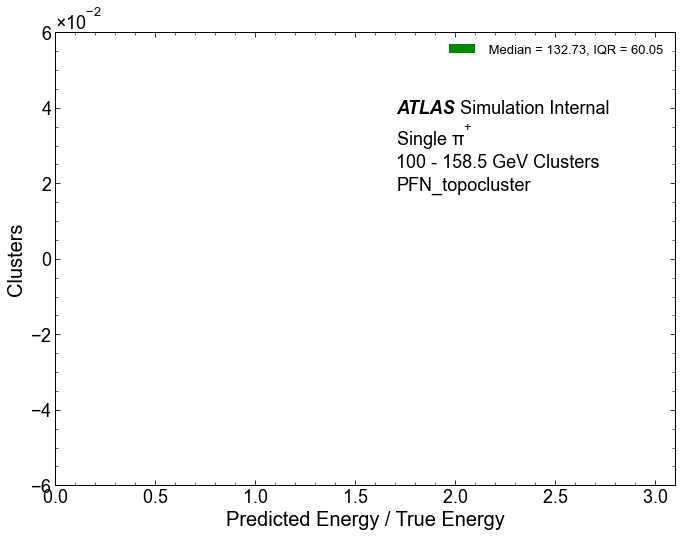

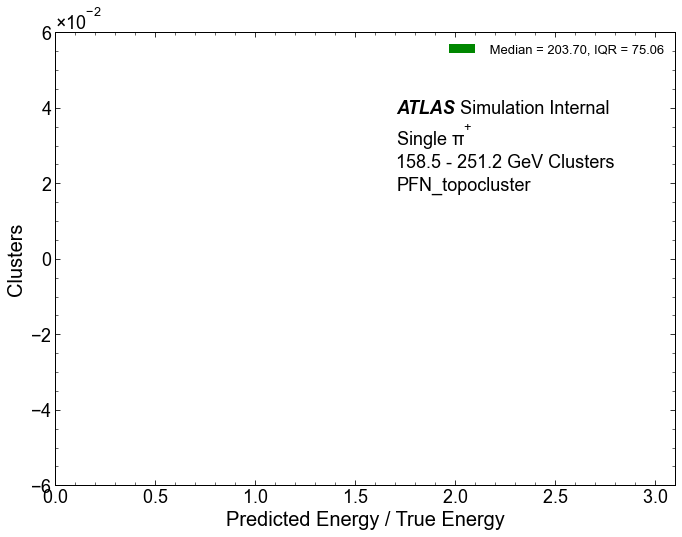

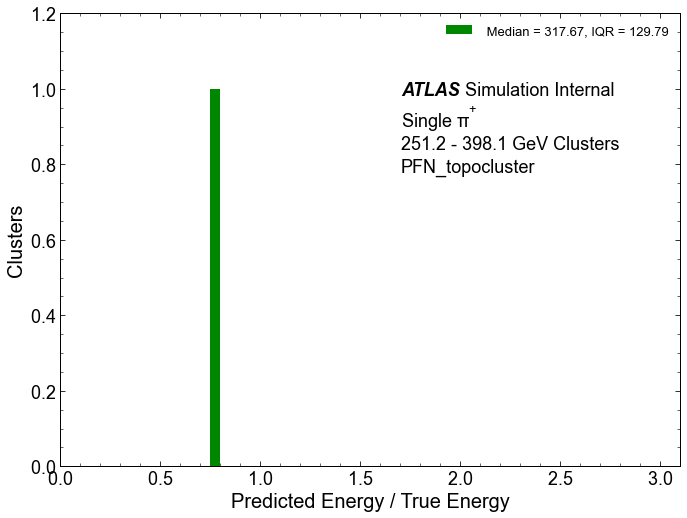

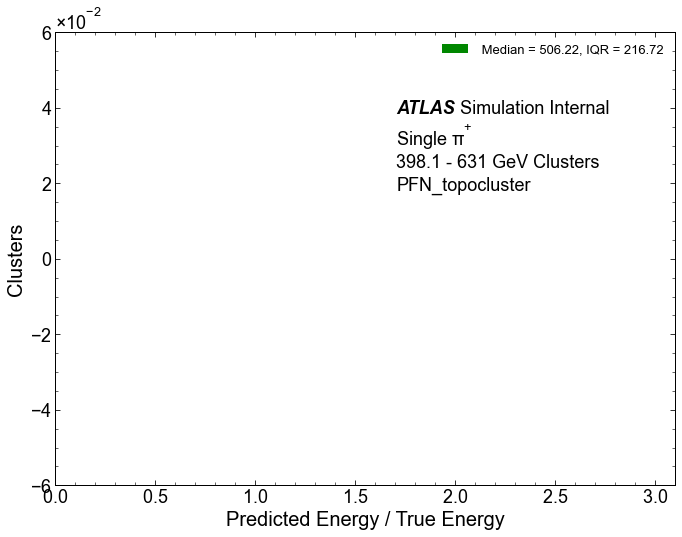

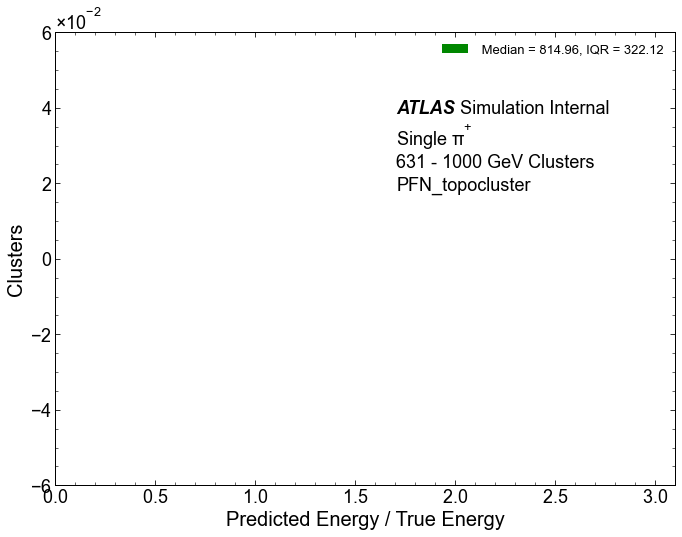

In [75]:
histogramSlices(y, pred,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'PFN_topocluster'}])